In [58]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize

In [ ]:
mooring_shelfExtended_kogur = xr.open_dataset(r'D:\MScData\mooring_shelfExtended_kogur.nc')
mooring_shelfExtended = xr.open_dataset(r'D:\MScData\mooring_shelfExtended.nc')
mooring_kogur = xr.open_dataset(r'D:\MScData\mooring_kogur.nc')
mooring_north = xr.open_dataset(r'D:\MScData\mooring_north.nc')
depth = xr.open_dataset(r'D:\MScData\Depth_res.nc')['Depth'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth_no_nan = depth
FW_input = xr.open_dataset(r'D:\MScData\oceFWflx.nc')['oceFWflx'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
FW_input2 = xr.open_dataset(r'D:\MScData\SIatmFW.nc')['SIatmFW'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
area = xr.open_dataset(r'D:\MScData\rA.nc')['rA'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth = depth.where(depth > 0, np.nan)

Text(0.5, 1.0, 'Masked Data')

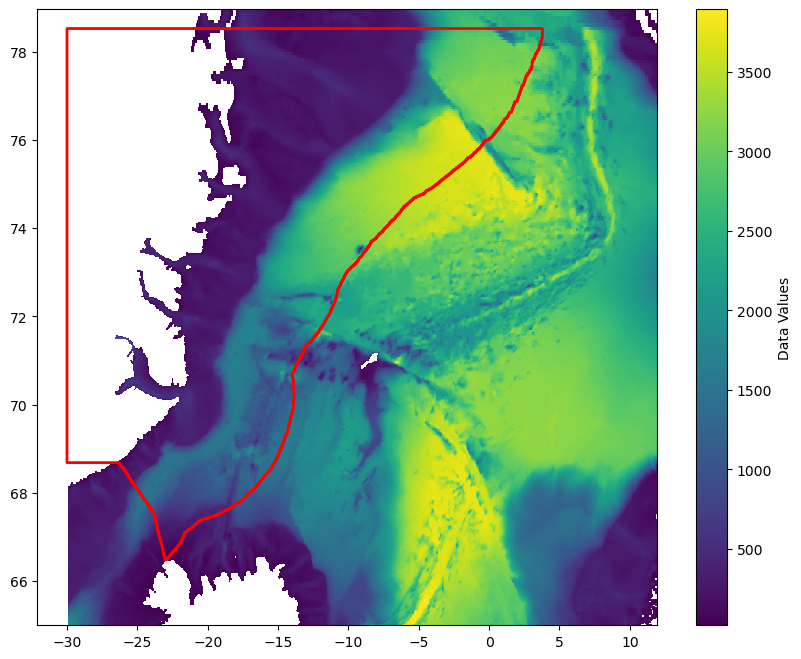

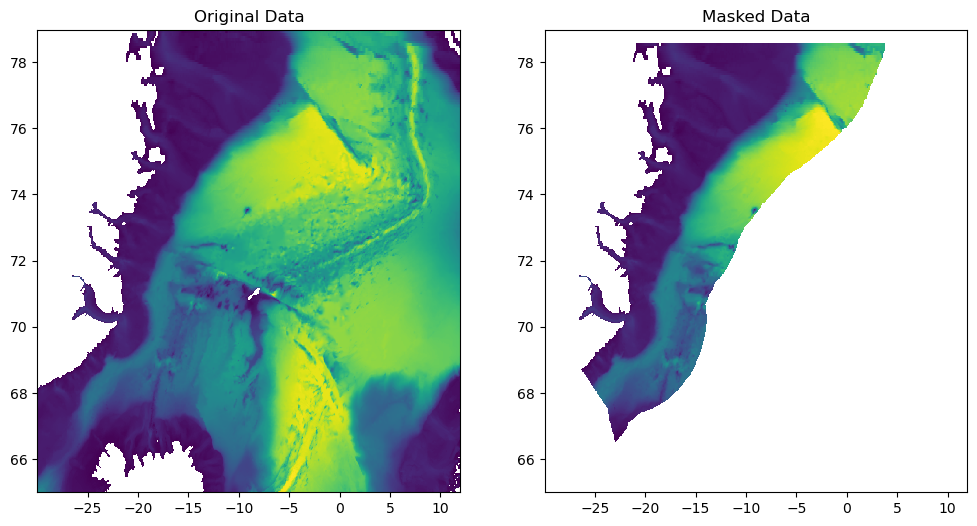

In [60]:
# Domain: (Y=slice(65,79)).sel(X=slice(-30,12))

cond = mooring_north == mooring_north.XC <= 3.788806
mooring_north = mooring_north.where(cond,drop=True)

XC_north = [mooring_north["XC"][x].values[0][0] for x in mooring_north['mooring']]
YC_north = [mooring_north["YC"][x].values[0][0] for x in mooring_north['mooring']]

XC_east1 = [mooring_shelfExtended["XC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
YC_east1 = [mooring_shelfExtended["YC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
XC_east2 = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC_east2 = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]

XC_south = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC_south = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]

# Define western boundary coordinates (example coordinates, replace with actual)
XC_west = [-30] * len(np.linspace(YC_south[0], YC_north[0], 100))  # Replace with actual western boundary X coordinates
YC_west = np.linspace(YC_south[0], YC_north[0], 100)  # Replace with actual western boundary Y coordinates

# Combine boundary coordinates into a single list of tuples
boundary_coords = list(zip(XC_north, YC_north)) + \
                  list(zip(XC_east1, YC_east1)) + \
                  list(zip(XC_east2, YC_east2)) + \
                  list(zip(XC_south[::-1], YC_south[::-1])) + \
                  list(zip(XC_west, YC_west))

data = depth

# Create a Path object from the boundary coordinates
boundary_path = Path(boundary_coords)

# Plot the data and the boundary path
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data
pcm = ax.pcolormesh(data.XC, data.YC, data, shading='auto', cmap='viridis')
fig.colorbar(pcm, ax=ax, label='Data Values')

# Plot the boundary path
boundary_coords.append(boundary_coords[0])  # Close the polygon
boundary_lon, boundary_lat = zip(*boundary_coords)
ax.plot(boundary_lon, boundary_lat, 'r-', linewidth=2, label='Boundary Path')

# Create a mask based on whether points are inside the boundary path
mask = np.zeros(data.shape, dtype=bool)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        point = (data.XC[i, j], data.YC[i, j])
        if not boundary_path.contains_point(point):
            mask[i, j] = True

# Apply the mask to the data
masked_data = np.ma.masked_array(data, mask)

# Plot the original and masked data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original data
ax[0].pcolormesh(data.XC, data.YC, data, shading='auto')
ax[0].set_title('Original Data')

# Masked data
ax[1].pcolormesh(data.XC, data.YC, masked_data, shading='auto')
ax[1].set_title('Masked Data')

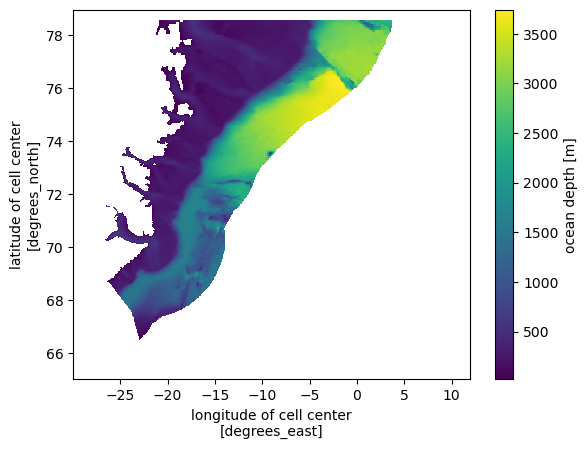

In [61]:
data.where(~mask).plot()

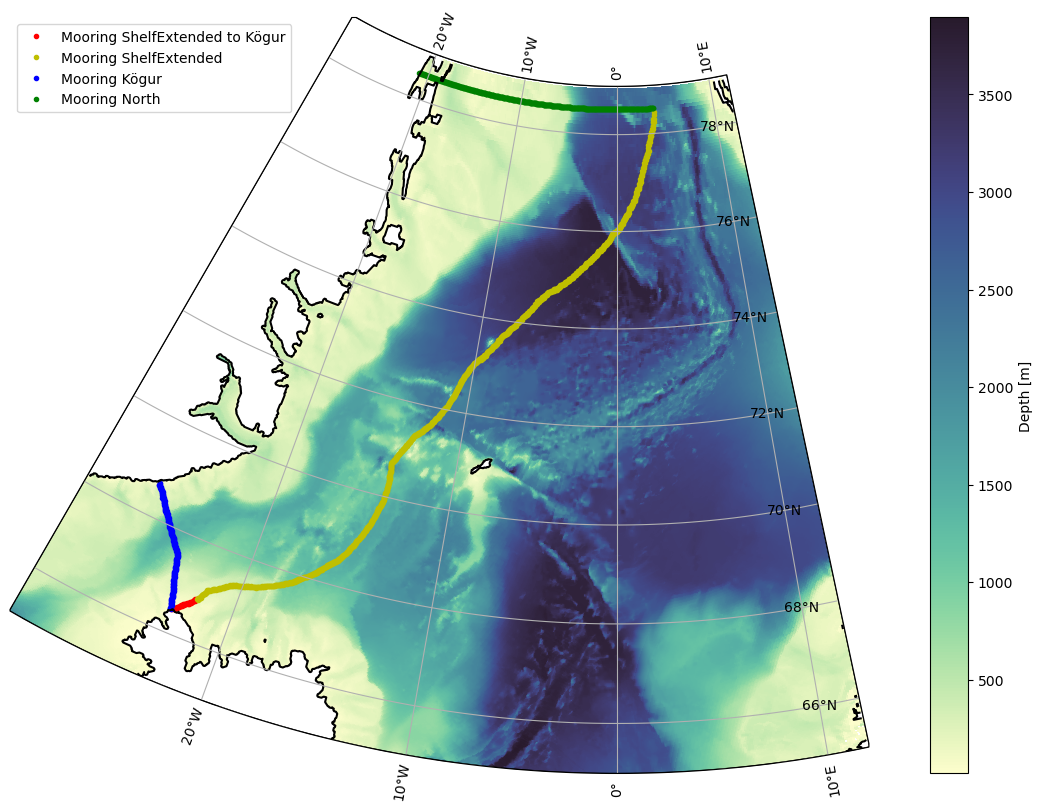

In [62]:
# Plot map and mooring locations
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained') # central_longitude=-10

extent = [-30,12,65,79]

mesh = ax.pcolormesh(depth.X, depth.Y, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('Depth [m]')

XC = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
ax.plot(XC, YC, "r.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended to Kögur')

XC = [mooring_shelfExtended["XC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
YC = [mooring_shelfExtended["YC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
ax.plot(XC, YC, "y.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended')

XC = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]
ax.plot(XC, YC, "b.", transform=ccrs.PlateCarree(), label='Mooring Kögur')

XC = [mooring_north["XC"][x].values[0][0] for x in mooring_north['mooring']]
YC = [mooring_north["YC"][x].values[0][0] for x in mooring_north['mooring']]
ax.plot(XC, YC, "g.", transform=ccrs.PlateCarree(), label='Mooring North')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')

In [63]:
display(FW_input)
FW_input = FW_input.mean(dim='time')*area/1000 * 1/1000 # One m^3 is 1000L == 1000kg, thus to convert it into mSv we divide by 1/1000000
FW_input2 = FW_input2.mean(dim='time')*area/1000 * 1/1000

FW_input = FW_input.where(~mask)
FW_input2 = FW_input2.where(~mask)

# FW_input = FW_input.where(FW_input>0,other=np.nan)
# FW_input2 = FW_input2.where(FW_input2>0,other=np.nan)

<xarray.DataArray 'oceFWflx' (time: 1460, Y: 628, X: 765)>
[701413200 values with dtype=float64]
Coordinates:
  * X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.62 11.72 11.82 11.92
  * Y        (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2017-09-01 ... 2018-08-31T18:00:00
Attributes:
    description:    net surface Fresh-Water flux into the ocean (+=down), >0 ...
    units:          kg/m^2/s
    standard_name:  oceFWflx
    long_name:      net surface Fresh-Water flux into the ocean (+=down), >0 ...

In [64]:
display(FW_input2)

<xarray.DataArray (Y: 628, X: 765)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.62 11.72 11.82 11.92
  * Y        (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    XC       (Y, X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
    YC       (Y, X) float64 65.01 65.01 65.01 65.01 ... 78.92 78.92 78.92 78.92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Tot. Amount: 30.15622140803085 mSv')

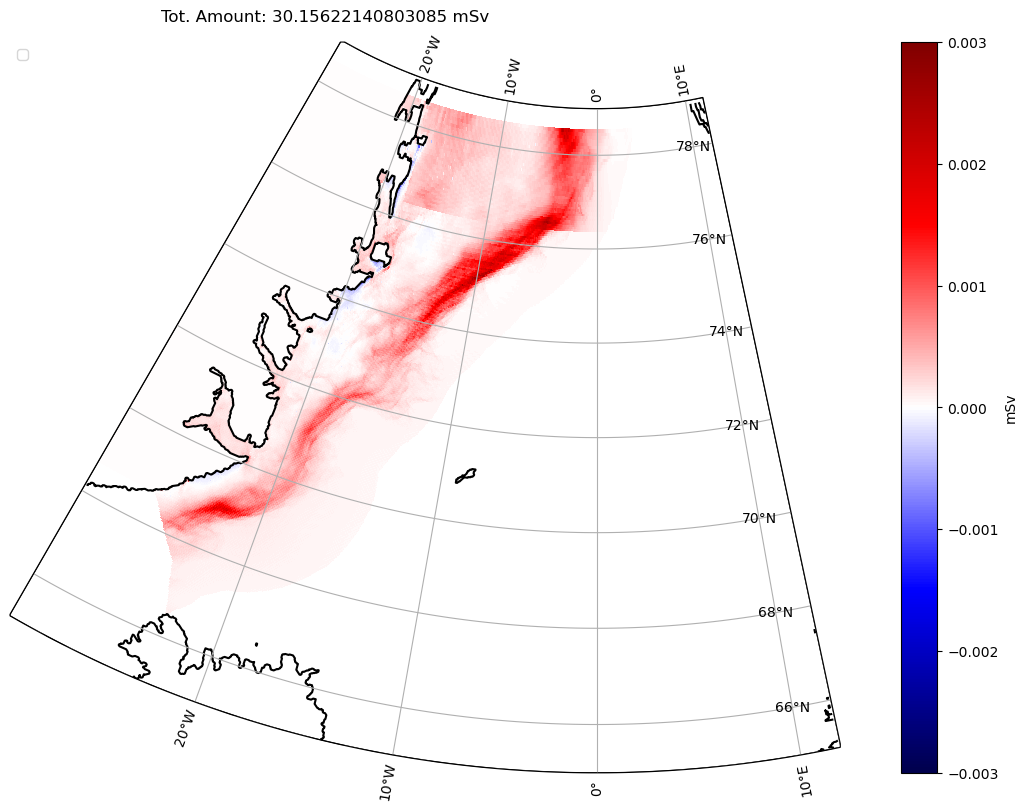

In [65]:
# Plot FW input
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained') # central_longitude=-10

extent = [-30,12,65,79]

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())

mesh = ax.pcolormesh(FW_input.X, FW_input.Y, FW_input, cmap='seismic',vmin=-0.003,vmax=0.003,transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('mSv')



# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')
fig.suptitle(f'Tot. Amount: {FW_input.sum().values} mSv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Tot. Amount: 10.281131886013211 mSv')

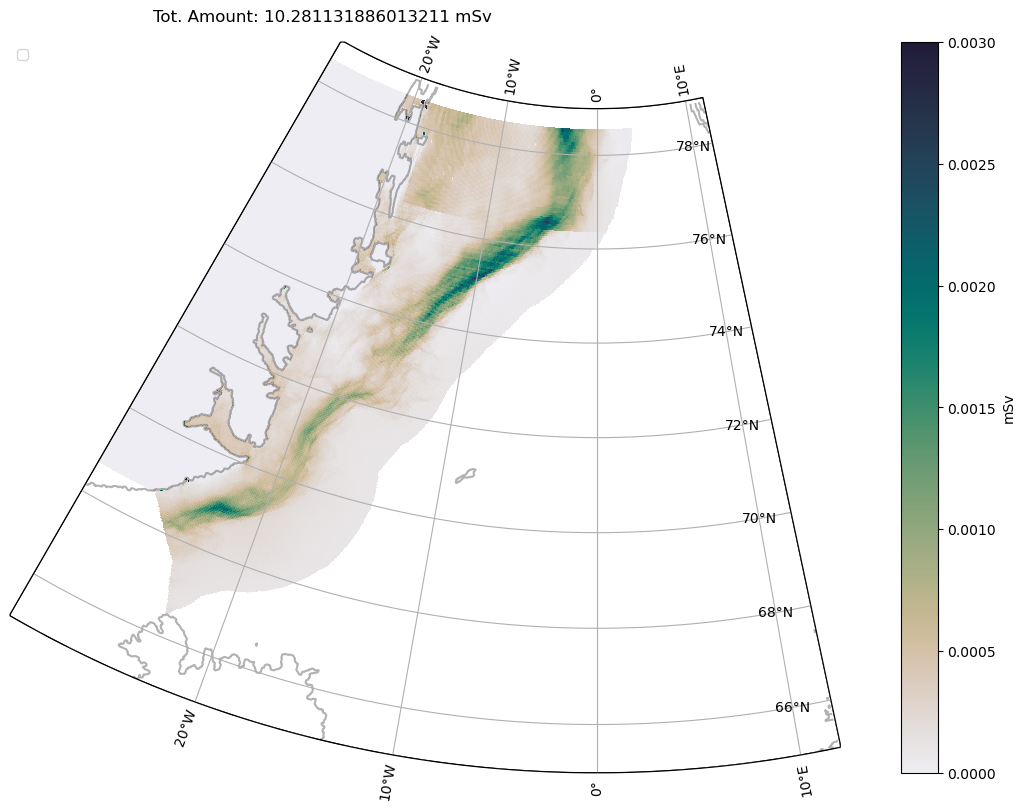

In [66]:
# Plot FW input
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained') # central_longitude=-10

extent = [-30,12,65,79]


mesh = ax.pcolormesh(FW_input2.X, FW_input2.Y, FW_input2 + FW_input, cmap=cmo.rain,vmin=0,vmax=0.003,transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('mSv')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree(),alpha=0.3)

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')
fig.suptitle(f'Tot. Amount: {FW_input2.sum().values} mSv')

In [67]:
from FW import FWT
ref_salinity = 34.734637631708175

In [68]:
try:
    kogur_r_ds = xr.open_dataset(r'D:\MScData\kogur_transport.nc')
except:   
    kogur_r = FWT(mooringDataset=mooring_kogur,ref_salinity=ref_salinity)

In [69]:
try:
    shelfExtended_r_ds = xr.open_dataset(r'D:\MScData\shelfExtended_transport.nc')
except:
    shelfExtended_r = FWT(mooringDataset=mooring_shelfExtended,ref_salinity=ref_salinity)

In [70]:
try:
    shelfExtendedKogur_r_ds = xr.open_dataset(r'D:\MScData\shelfExtendedKogur_transport.nc')
except:
    shelfExtendedKogur_r = FWT(mooringDataset=mooring_shelfExtended_kogur,ref_salinity=ref_salinity)

In [71]:
try:
    north_r_ds = xr.open_dataset(r'D:\MScData\north_transport.nc')
except:
    north_r = FWT(mooringDataset=mooring_north,ref_salinity=ref_salinity)

In [72]:
# display(kogur_r,north_r,shelfExtended_r,shelfExtendedKogur_r)

In [73]:
# List of file paths
file_paths = [
    r'D:\MScData\kogur_transport.nc',
    r'D:\MScData\north_transport.nc',
    r'D:\MScData\shelfExtended_transport.nc',
    r'D:\MScData\shelfExtendedKogur_transport.nc'
]

try:
    kogur_r = kogur_r_ds['kogur']
    north_r = north_r_ds['north']
    shelfExtended_r = shelfExtended_r_ds['shelfExtended']
    shelfExtendedKogur_r = shelfExtendedKogur_r_ds['shelfExtendedKogur']
except:
    # Create individual datasets
    kogur_ds = xr.Dataset({'kogur': kogur_r})
    north_ds = xr.Dataset({'north': north_r})
    shelfExtended_ds = xr.Dataset({'shelfExtended': shelfExtended_r})
    shelfExtendedKogur_ds = xr.Dataset({'shelfExtendedKogur': shelfExtendedKogur_r})

    # List of datasets
    datasets = [kogur_ds, north_ds, shelfExtended_ds, shelfExtendedKogur_ds]

    # Save multiple datasets to multiple files
    xr.save_mfdataset(datasets, file_paths)

    

kogur = kogur_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
north = north_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
shelfExtended = shelfExtended_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
shelfExtendedKogur = shelfExtendedKogur_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)

In [74]:
display(kogur)

<xarray.DataArray 'kogur' (Z: 216, mooring: 199)>
array([[            nan, -2.37423301e-05, -2.52749211e-05, ...,
        -3.02458782e-07,  3.40053428e-08,             nan],
       [            nan, -3.34990436e-05, -3.53266710e-05, ...,
        -2.63085613e-07,  1.04675707e-07,             nan],
       [            nan, -4.17238566e-05, -4.37478795e-05, ...,
         1.14616889e-07,  2.41812207e-07,             nan],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * Z                   (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * mooring             (mooring) int64 0 1 2 3 4 5 ... 193 194 195 196 197 198
    drF                 (Z) float64 ...
    kogur_mooring_dist  (mooring) float64 ...
    Y                   int64 0
    X                   int64 0
    XC                  (mooring) float64 ...
    YC                  (mooring) float64 ...
    Xind                (mooring) float64 ...
    Yind                (mooring) float64 ...

In [75]:
# Hist variables
kogur_ = kogur.sum(dim='Z')*1000
kogur_h_p = kogur_.where(kogur_>0)
kogur_h_n = kogur_.where(kogur_<0)

north_ = north.sum(dim='Z')*1000
cond1 = (north_>0) & ((north_.XC <= 3.788806))
cond2 = (north_<0) & ((north_.XC <= 3.788806))
north_h_p = north_.where(cond1)
north_h_n = north_.where(cond2)

shelfExtended_ = shelfExtended.sum(dim='Z')*1000
cond1 = (shelfExtended_>0)# & ((shelfExtended_.YC < 74) & (shelfExtended_.YC > 70))
cond2 = (shelfExtended_<0)# & ((shelfExtended_.YC < 74) & (shelfExtended_.YC > 70))
shelfExtended_h_p = shelfExtended_.where(cond1)
shelfExtended_h_n = shelfExtended_.where(cond2)

shelfExtendedKogur_ = shelfExtendedKogur.sum(dim='Z')*1000
shelfExtendedKogur_h_p = shelfExtendedKogur_.where(shelfExtendedKogur_>0)
shelfExtendedKogur_h_n = shelfExtendedKogur_.where(shelfExtendedKogur_<0)


In [76]:
display(shelfExtended)

<xarray.DataArray 'shelfExtended' (Z: 216, mooring: 1054)>
array([[            nan,  2.41925450e-05,  1.54760635e-05, ...,
        -2.19285185e-05, -3.83094938e-06,             nan],
       [            nan,  3.82826225e-05,  2.45390718e-05, ...,
        -3.15254349e-05, -5.84845483e-06,             nan],
       [            nan,  5.00394617e-05,  3.22415273e-05, ...,
        -3.95755615e-05, -7.45651507e-06,             nan],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * Z                           (Z) float64 -1.0 -3.5 ... -3.922e+03 -3.942e+03
  * mooring                     (mooring) int64 0 1 2 3 ... 1050 1051 1052 1053
    drF                         (Z) float64 ...
    shelfExtended_mooring_dist  (mooring) float64 ...
    Y                           int64 0
    X                           int64 0
    XC                          (mooring) float64 ...
    YC                          (mooring) float64 ...
    Xind                        (mooring) float64 ...
    Yind                        (mooring) float64 ...

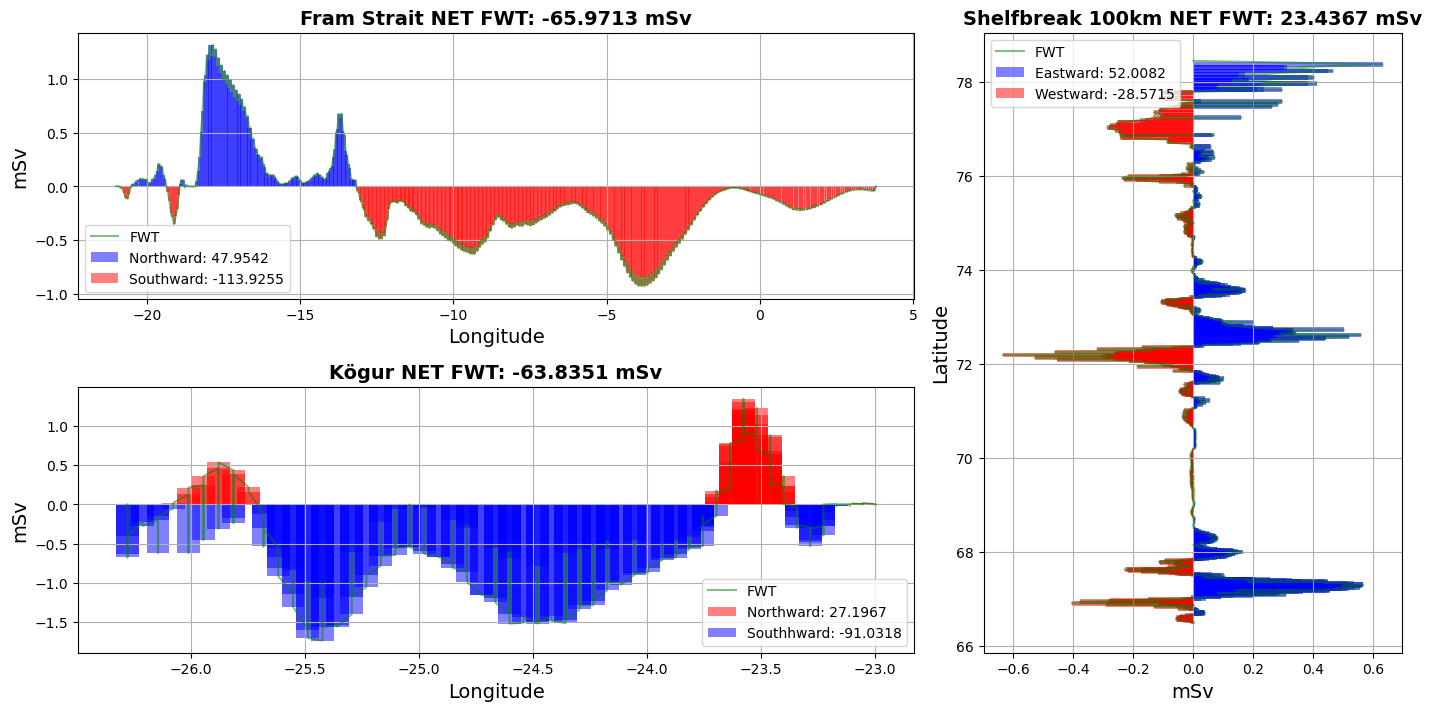

In [77]:
fig, axd = plt.subplot_mosaic([['ul','r'],
                               ['ll','r']],
                               gridspec_kw={'width_ratios': [1, 0.5]},
                               figsize=(14,7), layout='constrained')

axd['ul'].plot(north.XC,north.sum(dim='Z')*1000,color='g',alpha=0.5,label='FWT')
axd['ul'].set_title(f'Fram Strait NET FWT: {np.round(north_h_n.sum().values+north_h_p.sum().values,4)} mSv',fontweight='bold',fontsize=14)
axd['ul'].grid()
axd['ul'].bar(north.XC, north_h_p, width=0.1, color='blue', alpha=0.5,label=f'Northward: {np.round(north_h_p.sum().values,4)}')
axd['ul'].bar(north.XC, north_h_n, width=0.1, color='red', alpha=0.5,label=f'Southward: {np.round(north_h_n.sum().values,4)}')
axd['ul'].set_xlabel('Longitude',fontsize=14)
axd['ul'].set_ylabel('mSv',fontsize=14)
axd['ul'].legend()

axd['ll'].plot(kogur.XC,kogur.sum(dim='Z')*1000,color='g',alpha=0.5,label='FWT')
axd['ll'].set_title(f'Kögur NET FWT: {np.round(kogur.sum(dim="Z").sum(dim="mooring").values*1000,4)} mSv',fontweight='bold',fontsize=14)
axd['ll'].grid()
axd['ll'].bar(kogur.XC, kogur_h_p, width=0.1, color='red', alpha=0.5,label=f'Northward: {np.round(kogur_h_p.sum().values,4)}')
axd['ll'].bar(kogur.XC, kogur_h_n, width=0.1, color='blue', alpha=0.5,label=f'Southhward: {np.round(kogur_h_n.sum().values,4)}')
axd['ll'].set_xlabel('Longitude',fontsize=14)
axd['ll'].set_ylabel('mSv',fontsize=14)
axd['ll'].legend()

axd['r'].plot(shelfExtended.sum(dim='Z')*1000, shelfExtended.YC,color='g',alpha=0.5,label='FWT')
axd['r'].set_title(f'Shelfbreak 100km NET FWT: {np.round(shelfExtended.sum(dim="Z").sum(dim="mooring").values*1000 + shelfExtendedKogur.sum(dim="Z").sum(dim="mooring").values*1000,4)} mSv',fontweight='bold',fontsize=14)
axd['r'].barh(shelfExtended.YC, shelfExtended_h_p, height=0.1, color='blue', alpha=0.5, label=f'Eastward: {np.round(shelfExtended_h_p.sum().values+shelfExtendedKogur_h_p.sum().values,4)}')
axd['r'].barh(shelfExtended.YC, shelfExtended_h_n, height=0.1, color='red', alpha=0.5, label=f'Westward: {np.round(shelfExtended_h_n.sum().values+shelfExtendedKogur_h_n.sum().values,4)}')

axd['r'].plot(shelfExtendedKogur.sum(dim='Z')*1000, shelfExtendedKogur.YC,color='g',alpha=0.5)
axd['r'].barh(shelfExtendedKogur.YC, shelfExtendedKogur_h_p, height=0.1, color='blue', alpha=0.5)
axd['r'].barh(shelfExtendedKogur.YC, shelfExtendedKogur_h_n, height=0.1, color='red', alpha=0.5)
axd['r'].set_ylabel('Latitude',fontsize=14)
axd['r'].set_xlabel('mSv',fontsize=14)
axd['r'].grid()
axd['r'].legend()
plt.savefig(r'C:\Users\eirik\Master\Figures\FW_Budget_boundary')

Text(0.5, 1.0, 'Kögur')

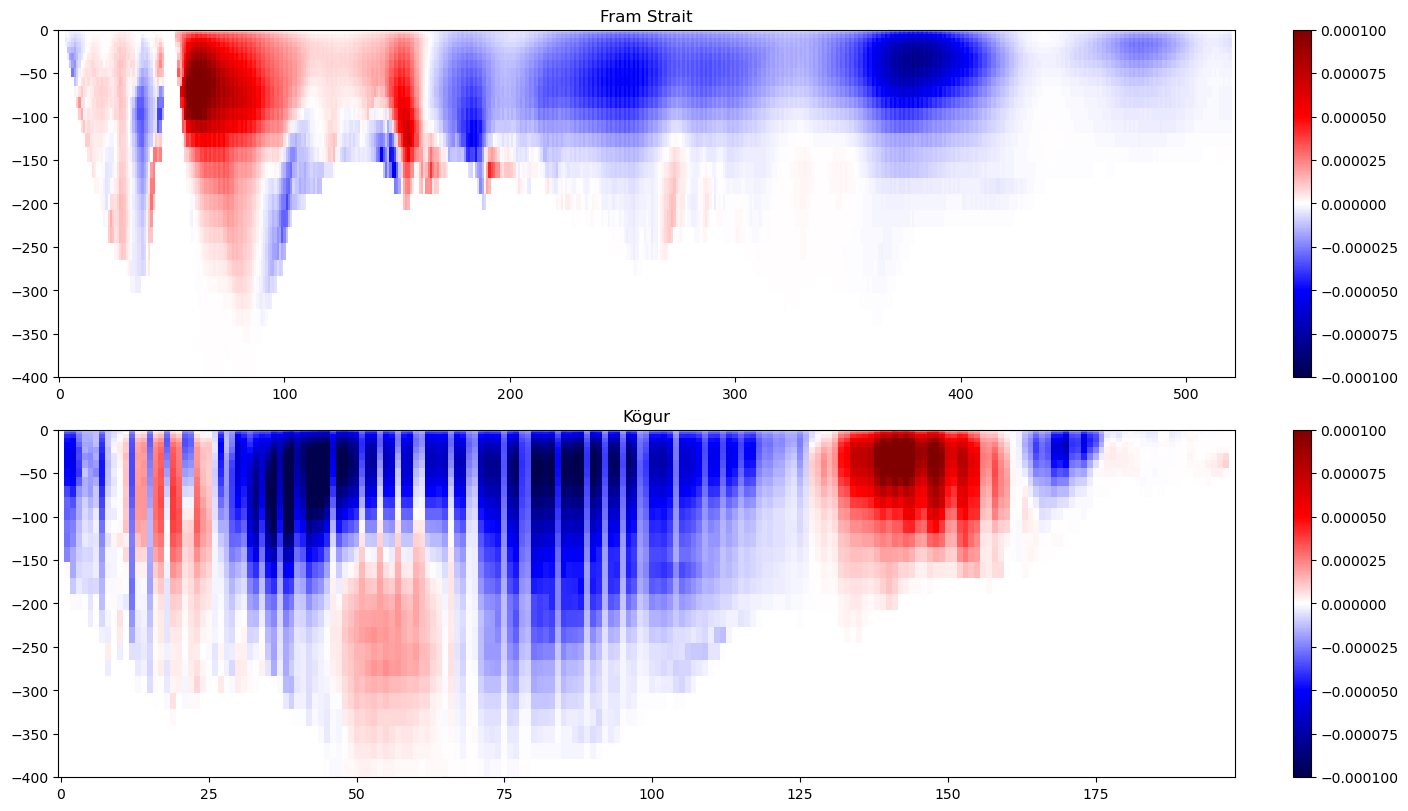

In [78]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),layout='constrained')
mesh = ax1.pcolormesh(north.mooring,north.Z,north,cmap='seismic',vmin=-0.0001,vmax=0.0001)
cbar = fig.colorbar(mesh)
ax1.set_ylim(-400,0)
ax1.set_title('Fram Strait')

mesh = ax2.pcolormesh(kogur.mooring,kogur.Z,kogur,cmap='seismic',vmin=-0.0001,vmax=0.0001)
cbar = fig.colorbar(mesh)
ax2.set_ylim(-400,0)
ax2.set_title('Kögur')

# Shelfbreak 100km

# Could do
- Shifted correlation of time series of FWT of each transect
- Mask pos/neg numb
- Usikkerhet i referanse salinitet

In [79]:
import pandas as pd

# kogur_m = kogur_r.resample(time='ME').mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
# north_m = north_r.resample(time='ME').mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
# shelfExtended_m = shelfExtended_r.resample(time='ME').mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
# shelfExtendedKogur_m = shelfExtendedKogur_r.resample(time='ME').mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')

def resample_and_shift(data):
    resampled_data = data.resample(time='M').mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
    # Calculate the midpoint of the current month
    new_time = []
    for date in resampled_data['time'].values:
        date = pd.Timestamp(date)
        start_of_month = date.replace(day=1)
        end_of_month = (start_of_month + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
        midpoint_of_month = start_of_month + (end_of_month - start_of_month) / 2
        new_time.append(midpoint_of_month)
    resampled_data['time'] = new_time
    return resampled_data

# Apply the function to each dataset
kogur_m = resample_and_shift(kogur_r)
north_m = resample_and_shift(north_r)
shelfExtended_m = resample_and_shift(shelfExtended_r)
shelfExtendedKogur_m = resample_and_shift(shelfExtendedKogur_r)

kogur_d = kogur_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
north_d = north_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
shelfExtended_d = shelfExtended_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
shelfExtendedKogur_d = shelfExtendedKogur_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')

c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [80]:
def cross_correlation(ts1, ts2, lag):
    ts2_shifted = ts2.shift(time=lag)
    valid = ts2_shifted.notnull()
    return np.corrcoef(ts1[valid], ts2_shifted[valid])[0, 1]


lags = range(-12, 13)  # Define the range of lags you want to test
correlations1 = [cross_correlation(north_m, kogur_m, lag) for lag in lags]
correlations2 = [cross_correlation(north_m, shelfExtended_m+shelfExtendedKogur_m, lag) for lag in lags]


# plt.plot(lags, correlations)
# plt.xlabel('Lag')
# plt.ylabel('Correlation')
# plt.title('Cross-Correlation between ts1 and ts2')
# plt.show()



c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **ke

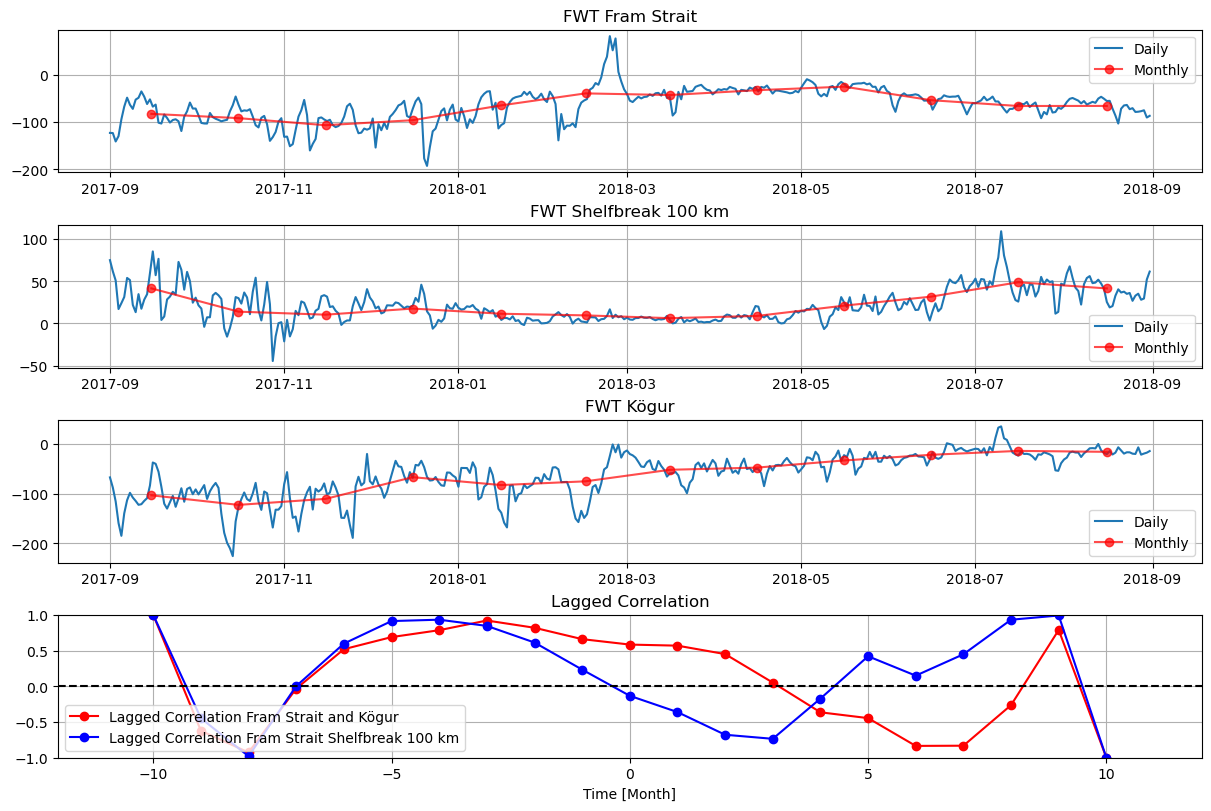

In [81]:
fig, axs = plt.subplot_mosaic([[0],
                               [1],
                               [2],
                               [3]],
                               figsize=(12,8),layout='constrained')

# North section
axs[0].plot(north_d.time,north_d*1000,label='Daily')
axs[0].plot(north_m.time,north_m*1000,'r-o',alpha=0.7,label='Monthly')
axs[0].set_title('FWT Fram Strait')
axs[0].grid()
axs[0].legend()

axs[1].plot(shelfExtended_d.time,shelfExtended_d*1000 + shelfExtendedKogur_d*1000,label='Daily')
axs[1].plot(shelfExtended_m.time,shelfExtended_m*1000 + shelfExtendedKogur_m*1000,'r-o',alpha=0.7,label='Monthly')
axs[1].set_title('FWT Shelfbreak 100 km')
axs[1].grid()
axs[1].legend()

axs[2].plot(kogur_d.time,kogur_d*1000,label='Daily')
axs[2].plot(kogur_m.time,kogur_m*1000,'r-o',alpha=0.7,label='Monthly')
axs[2].set_title('FWT Kögur')
axs[2].grid()
axs[2].legend()

axs[3].plot(lags,correlations1,'r-o', label='Lagged Correlation Fram Strait and Kögur')
axs[3].plot(lags,correlations2, 'b-o', label='Lagged Correlation Fram Strait Shelfbreak 100 km')
axs[3].plot(lags,[0 for i in lags],color='black',linestyle='--')
axs[3].set_ylim(-1,1)
axs[3].set_xlim(-12,12)
axs[3].set_title('Lagged Correlation')
axs[3].set_xlabel('Time [Month]')
axs[3].grid()
axs[3].legend()
plt.savefig(r'C:\Users\eirik\Master\Figures\FW_budget_time')

In [82]:
display(FW_input2)

<xarray.DataArray (Y: 628, X: 765)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.62 11.72 11.82 11.92
  * Y        (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    XC       (Y, X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
    YC       (Y, X) float64 65.01 65.01 65.01 65.01 ... 78.92 78.92 78.92 78.92

In [83]:
FW_input2_plot_X = []
FW_input2_plot_Y = []
FW_input2_plot = []

for j in FW_input2:
    for i in j:
        if i.values > 0.0003:
            FW_input2_plot_X.append([i.XC.values])
            FW_input2_plot_Y.append([i.YC.values])
            FW_input2_plot.append(i.values)

In [84]:
print('Land runoff: ',np.sum(FW_input2_plot),' mSv')
print('Land and precipitation: ', FW_input2.sum().values, 'mSv')
print('Land runoff part: ', np.sum(FW_input2_plot)/FW_input2.sum().values * 100, ' %')

Land runoff:  0.17314775109228575  mSv
Land and precipitation:  10.281131886013211 mSv
Land runoff part:  1.684131212516023  %


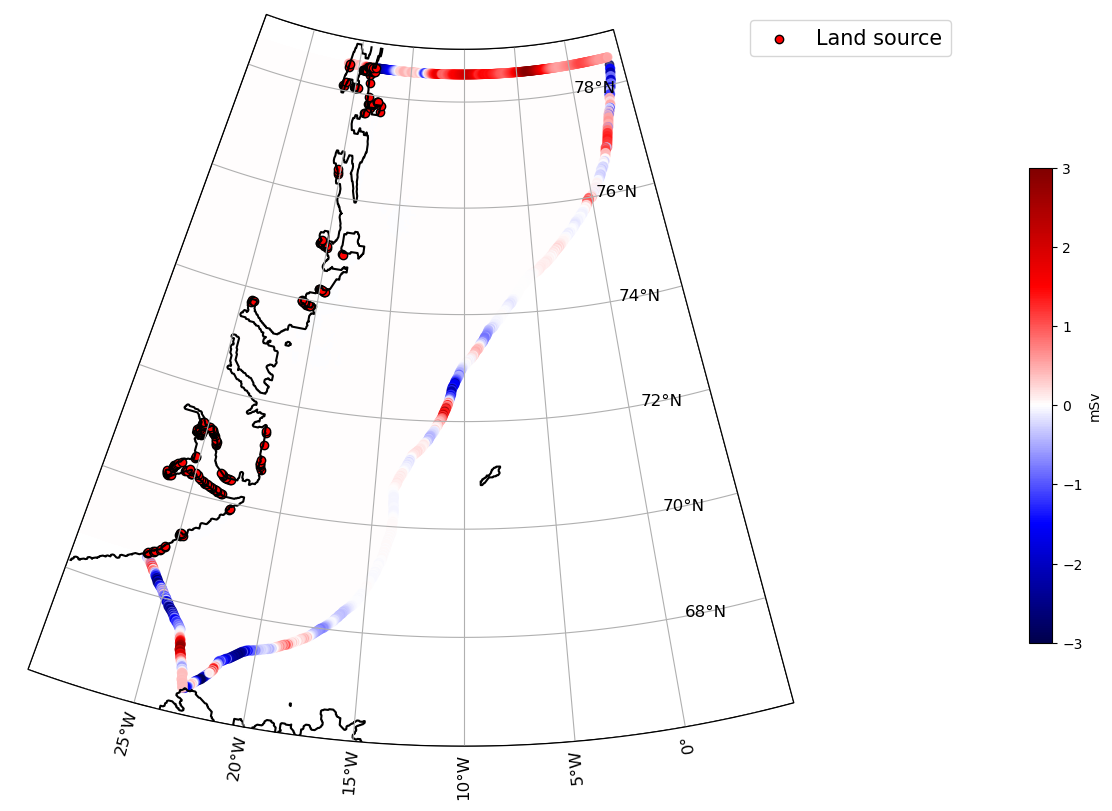

In [85]:
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
# Map of mean FWT from all variables

# Function to create a LineCollection
def create_line_collection(XC, YC, FWT_N, cmap, norm):
    # Create line segments
    points = np.array([XC, YC]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    lc.set_array(np.array(FWT_N))
    lc.set_linewidth(2)
    return lc

vmin=-3
vmax=3
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-30+10, 5+10, 66, 79]

lon = depth['XC']
lat = depth['YC']
cmap = plt.colormaps['seismic']
mesh = ax.pcolormesh(FW_input.X, FW_input.Y, FW_input, cmap=cmap,vmin=-3,vmax=3,transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh,shrink=0.6)
cbar.set_label('mSv')
# Add land contour
ax.contour(lon,lat,depth_no_nan,[0],colors='black', transform=ccrs.PlateCarree())

XC = [shelfExtendedKogur["XC"][x].values for x in shelfExtendedKogur['mooring']]
YC = [shelfExtendedKogur["YC"][x].values for x in shelfExtendedKogur['mooring']]
FWT_SEK = [-shelfExtendedKogur.sum(dim='Z')[x].values for x in shelfExtendedKogur['mooring']]
ax.scatter(XC, YC, c=FWT_SEK,cmap=cmap,alpha=0.7, transform=ccrs.PlateCarree())
# lc = create_line_collection(XC,YC,FWT_SEK,cmap=cmap,norm=norm)
#ax.add_collection(lc)

XC = [shelfExtended["XC"][x].values for x in shelfExtended['mooring']]
YC = [shelfExtended["YC"][x].values for x in shelfExtended['mooring']]
FWT_SE = [-shelfExtended.sum(dim='Z')[x].values for x in shelfExtended['mooring']]
ax.scatter(XC, YC, c=FWT_SE,cmap=cmap,alpha=0.7, transform=ccrs.PlateCarree())
# lc = create_line_collection(XC,YC,FWT_SE,cmap=cmap,norm=norm)
#ax.add_collection(lc)

XC = [kogur["XC"][x].values for x in kogur['mooring']]
YC = [kogur["YC"][x].values for x in kogur['mooring']]
FWT_K = [kogur.sum(dim='Z')[x].values for x in kogur['mooring']]
ax.scatter(XC, YC, c=FWT_K,cmap=cmap,alpha=0.7, transform=ccrs.PlateCarree())

XC = [north["XC"][x].values for x in north['mooring']]
YC = [north["YC"][x].values for x in north['mooring']]
FWT_N = [-north.sum(dim='Z')[x].values for x in north['mooring']]
ax.scatter(XC, YC, c=FWT_N,cmap=cmap,alpha=0.7, transform=ccrs.PlateCarree())

ax.scatter(FW_input2_plot_X,FW_input2_plot_Y,color='r',transform=ccrs.PlateCarree(),edgecolor='black',label='Land source')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)


# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}


# Add the combined legend
ax.legend(loc='upper right',prop={"size": 15})
plt.savefig(r'C:\Users\eirik\Master\Figures\ModelFWTMap')

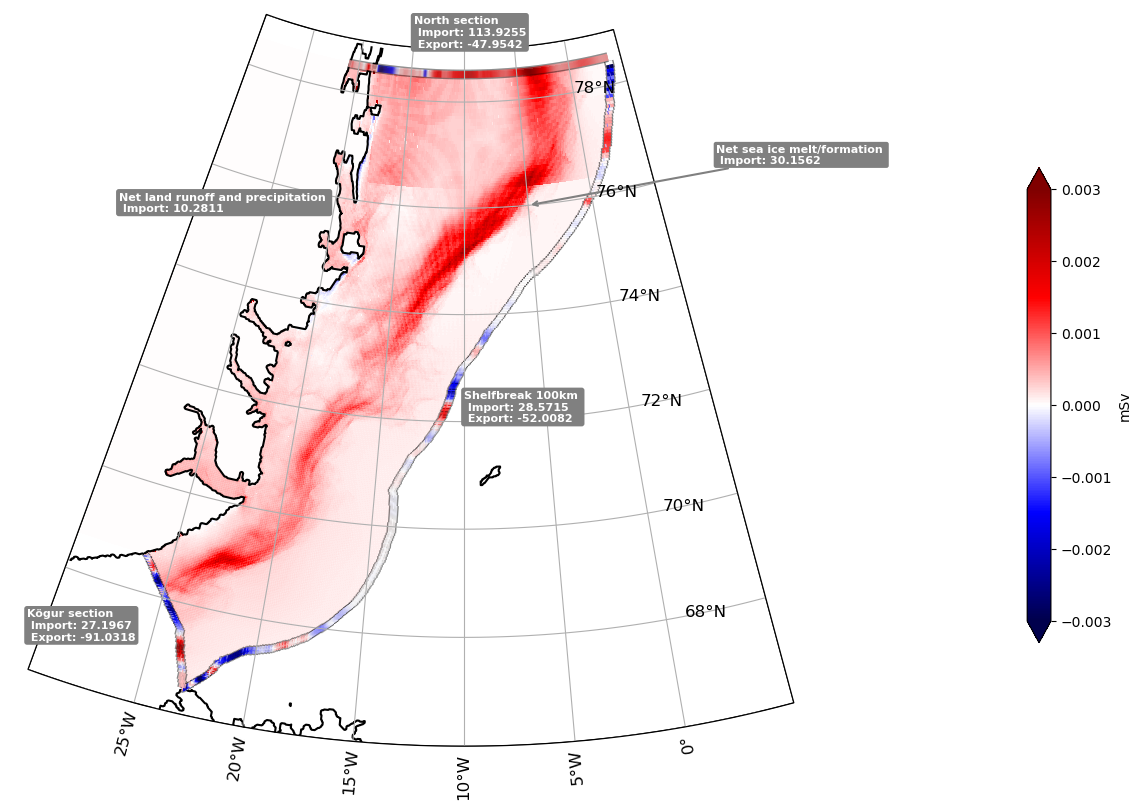

In [89]:
# Function to create a LineCollection
def create_line_collection_with_edgecolor(XC, YC, FWT_N, cmap, linewidth=5, edgecolor='black', edgewidth=7, edge_alpha=0.5):
    # Create line segments
    points = np.array([XC, YC]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the edge line collection
    edge_lc = LineCollection(segments, colors=[edgecolor], linewidths=edgewidth, alpha=edge_alpha, transform=ccrs.PlateCarree())

    # Create the main line collection
    main_lc = LineCollection(segments, cmap=cmap, transform=ccrs.PlateCarree())
    main_lc.set_array(np.array(FWT_N))
    main_lc.set_linewidth(linewidth)
    
    return edge_lc, main_lc


vmin = -0.003
vmax = 0.003
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-30+10, 5+10, 66, 79]

# Example data for testing
lon = depth['XC']
lat = depth['YC']
cmap = plt.get_cmap('seismic')
mesh = ax.pcolormesh(FW_input.X, FW_input.Y, FW_input + FW_input2, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh, shrink=0.6, extend='both')
cbar.set_label('mSv')

# Add land contour
ax.contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())

# Add the first FWT array
XC = [shelfExtendedKogur["XC"][x].values for x in shelfExtendedKogur['mooring']]
YC = [shelfExtendedKogur["YC"][x].values for x in shelfExtendedKogur['mooring']]
FWT_SEK = [-shelfExtendedKogur.sum(dim='Z')[x].values for x in shelfExtendedKogur['mooring']]
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_SEK, cmap=cmap)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)

# Add the second FWT array
XC = [shelfExtended["XC"][x].values for x in shelfExtended['mooring']]
YC = [shelfExtended["YC"][x].values for x in shelfExtended['mooring']]
FWT_SE = [-shelfExtended.sum(dim='Z')[x].values for x in shelfExtended['mooring']]
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_SE, cmap=cmap)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)

# Add the third FWT array as scatter plot
XC = [kogur["XC"][x].values for x in kogur['mooring']]
YC = [kogur["YC"][x].values for x in kogur['mooring']]
FWT_K = [kogur.sum(dim='Z')[x].values for x in kogur['mooring']]
# ax.scatter(XC, YC, c=FWT_K, cmap=cmap,norm=norm, alpha=0.7, transform=ccrs.PlateCarree())
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_K, cmap=cmap)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)

# Add the fourth FWT array as scatter plot
XC = [north["XC"][x].values for x in north['mooring']]
YC = [north["YC"][x].values for x in north['mooring']]
FWT_N = [-north.sum(dim='Z')[x].values for x in north['mooring']]
# ax.scatter(XC, YC, c=FWT_N, cmap=cmap,norm=norm, alpha=0.7, transform=ccrs.PlateCarree())
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_N, cmap=cmap)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)

# Add land source points
# ax.scatter(FW_input2_plot_X, FW_input2_plot_Y, c=FW_input2_plot, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.7,transform=ccrs.PlateCarree(), edgecolor='black', label='Land source')

# Text

texts = [
    (f'North section \n Import: {np.round(-north_h_n.sum().values,4)}\n Export: {np.round(-north_h_p.sum().values,4)}', -15, 79),
    (f'Shelfbreak 100km \n Import: {np.round(-shelfExtended_h_n.sum().values + -shelfExtendedKogur_h_n.sum().values,4)}\n Export: {np.round(-shelfExtended_h_p.sum().values + -shelfExtendedKogur_h_p.sum().values,4)}', -10, 72),
    (f'Kögur section \n Import: {np.round(kogur_h_p.sum().values,4)}\n Export: {np.round(kogur_h_n.sum().values,4)}', -30.5, 66.5),
    (f'Net land runoff and precipitation \n Import: {np.round(FW_input2.sum().values,4)}',-35,74.5)
]

for text, x, y in texts:
    ax.text(x, y, text, transform=ccrs.PlateCarree(),
            fontsize=8, weight='bold', color='white',
            bbox=dict(facecolor='grey', alpha=1, edgecolor='none', boxstyle='round,pad=0.25'))

text_location = (10, 76)
arrow_location = (-5, 76)

# Add the annotation with an arrow
ax.annotate(f'Net sea ice melt/formation \n Import: {np.round(FW_input.sum().values,4)}', 
            xy=arrow_location, 
            xytext=text_location, 
            fontsize=8, 
            weight='bold', 
            color='white',
            bbox=dict(facecolor='grey', alpha=1, edgecolor='none', boxstyle='round,pad=0.2'),
            arrowprops=dict(facecolor='grey', edgecolor='grey', arrowstyle='->', lw=1.5),
            transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Add the combined legend
# ax.legend(loc='upper right', prop={"size": 15})

# Show the plot
plt.draw()

# Save the figure
plt.savefig(r'C:\Users\eirik\Master\Figures\ModelFWTMap',dpi=300, bbox_inches='tight', pad_inches=0.1)